### Importing necessary libraries

In [ ]:
!pip install distance fuzzywuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=a0d33d63601018c3c5514ee62c1a993ed1d0e6db137266846387622f97aba886
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
import os
from os import path
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
import warnings
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/test.csv", encoding='utf-8')
df.shape

(3563475, 3)

In [ ]:
df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv", encoding='utf-8')
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Number of duplicate questions

<Axes: xlabel='is_duplicate'>

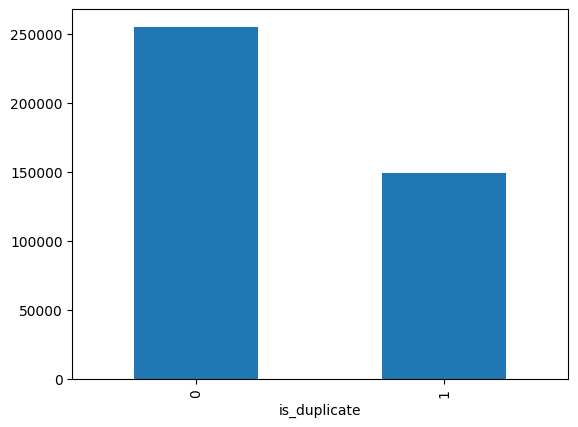

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('Total number of question pairs for training: {}'.format(len(df)))

Total number of question pairs for training: 404290


In [ ]:
print('Question pairs which are not Similar (is_duplicate = 0): {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nQuestion pairs which are Similar (is_duplicate = 1): {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Question pairs which are not Similar (is_duplicate = 0): 63.08%

Question pairs which are Similar (is_duplicate = 1): 36.92%


#### Calculating number of unique questions

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}'.format(unique_qs))

Total number of  Unique Questions are: 537933


In [ ]:
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
q_vals=qids.value_counts()

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)


In [ ]:
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))
q_vals=q_vals.values

Max number of times a single question is repeated: 157


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

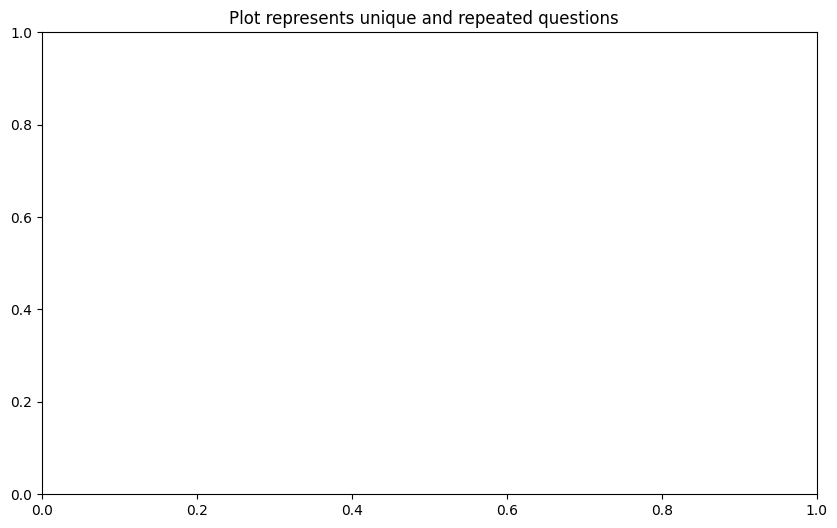

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot represents unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

#### Checking whether there are any duplicates present

In [ ]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions: ",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions:  0


In [ ]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


#### Checking for NULL values

In [ ]:
nan_rows = df[df.isnull().any()]
print(nan_rows)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

TypeError: NDFrame._add_numeric_operations.<locals>.any() takes 1 positional argument but 2 were given

#### Pre-cleaning feature extraction

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


#### Let's analyse over the feature word share and word count

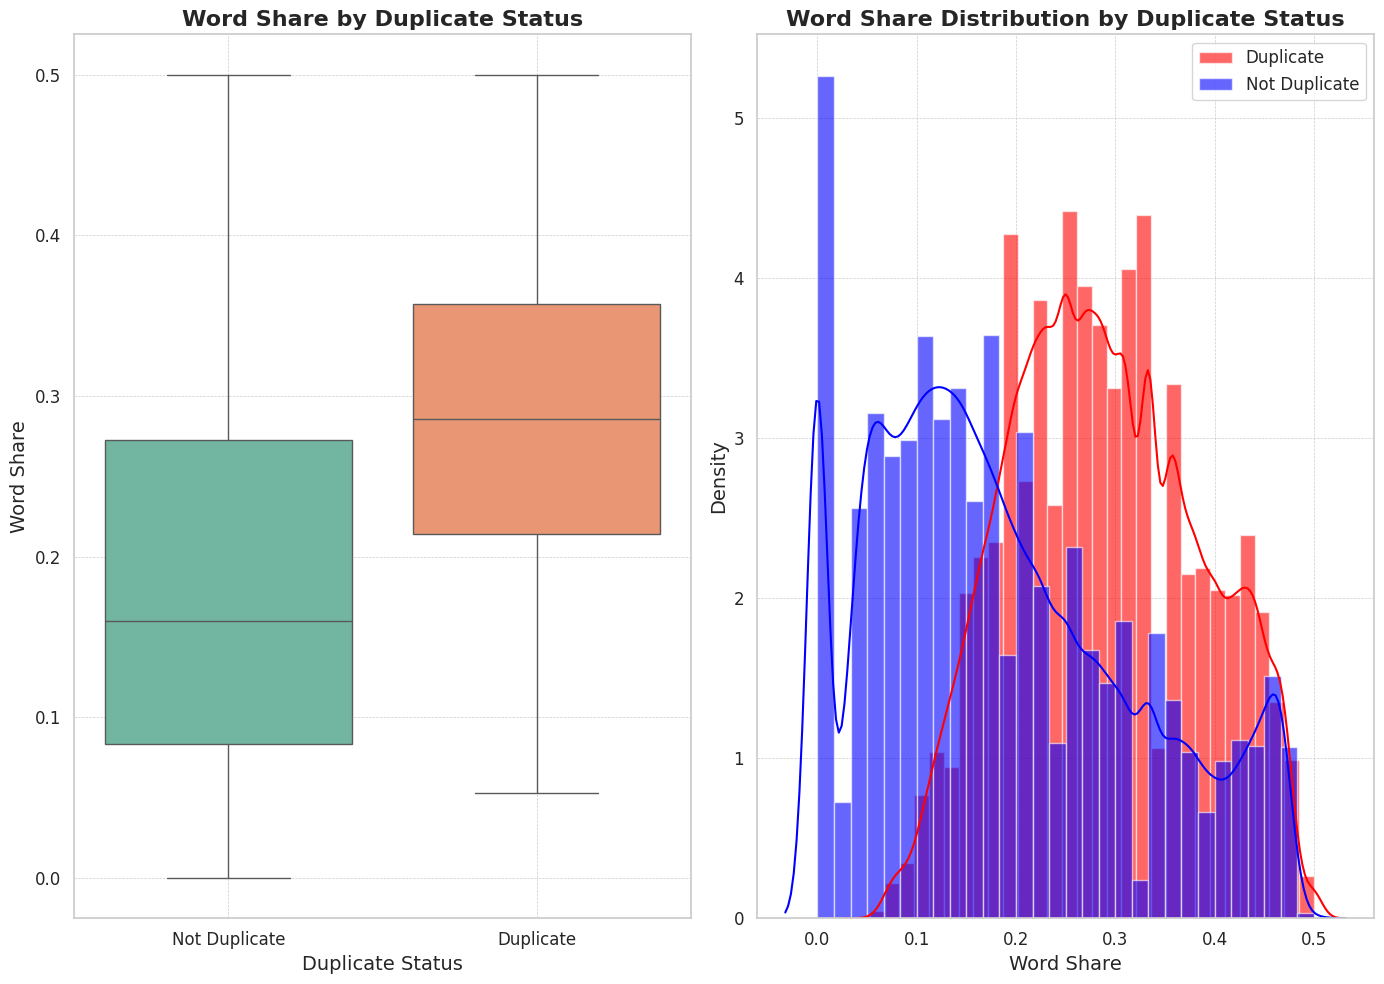

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Set the style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(14, 10))

# First subplot: Enhanced Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(x='is_duplicate', y='word_share', data=df, palette="Set2")
plt.title('Word Share by Duplicate Status', fontsize=16, fontweight='bold')
plt.xlabel('Duplicate Status', fontsize=14)
plt.ylabel('Word Share', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Duplicate', 'Duplicate'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Second subplot: Enhanced Histogram with Density Plots
plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label="Duplicate", color='red', kde=True, hist=True, bins=30, hist_kws={'alpha':0.6})
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label="Not Duplicate", color='blue', kde=True, hist=True, bins=30, hist_kws={'alpha':0.6})
plt.title('Word Share Distribution by Duplicate Status', fontsize=16, fontweight='bold')
plt.xlabel('Word Share', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

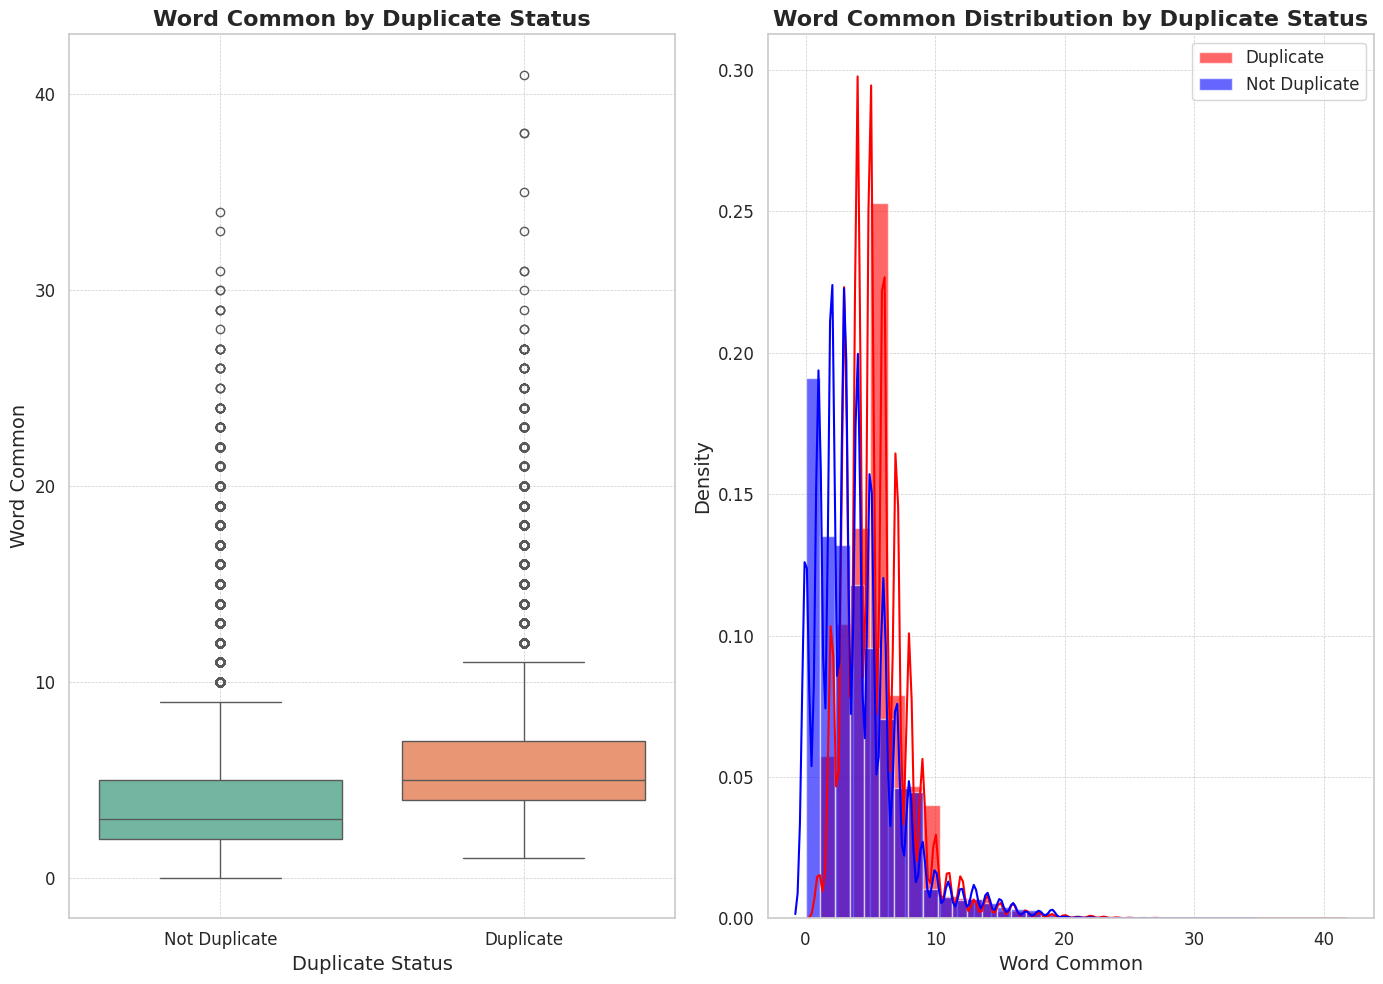

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Set the style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(14, 10))

# First subplot: Enhanced Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(x='is_duplicate', y='word_Common', data=df, palette="Set2")
plt.title('Word Common by Duplicate Status', fontsize=16, fontweight='bold')
plt.xlabel('Duplicate Status', fontsize=14)
plt.ylabel('Word Common', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Duplicate', 'Duplicate'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Second subplot: Enhanced Histogram with Density Plots
plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'], label="Duplicate", color='red', kde=True, hist=True, bins=30, hist_kws={'alpha':0.6})
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'], label="Not Duplicate", color='blue', kde=True, hist=True, bins=30, hist_kws={'alpha':0.6})
plt.title('Word Common Distribution by Duplicate Status', fontsize=16, fontweight='bold')
plt.xlabel('Word Common', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

### Preprocess the Data

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)


    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()

    return x

In [ ]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

print(df.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate  freq_qid1  \
0  what is the step by step guide to invest in sh...             0          1   
1  what would happen if the indian government sto...             0          4   
2  how can internet speed be increased by hacking...             0          1   
3  find the remainder when  math 23  24   math  i...             0          1   
4            which fish would survive in salt water              0          3   

   freq_qid2  len_q1  len_q2  no_words_q1  no_words_q2  word_Common  \
0        

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)


    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()


    return x

In [ ]:
def compute_token_features(question1, question2):
    features = [0.0] * 10

    # Tokenizing the questions
    tokens1 = question1.split()
    tokens2 = question2.split()

    if len(tokens1) == 0 or len(tokens2) == 0:
        return features

    # Extracting non-stopwords
    words1 = set([word for word in tokens1 if word not in STOP_WORDS])
    words2 = set([word for word in tokens2 if word not in STOP_WORDS])

    # Extracting stopwords
    stops1 = set([word for word in tokens1 if word in STOP_WORDS])
    stops2 = set([word for word in tokens2 if word in STOP_WORDS])

    # Counting common words and stops
    common_words = len(words1.intersection(words2))
    common_stops = len(stops1.intersection(stops2))
    common_tokens = len(set(tokens1).intersection(set(tokens2)))

    # Calculating features
    features[0] = common_words / (min(len(words1), len(words2)) + SAFE_DIV)
    features[1] = common_words / (max(len(words1), len(words2)) + SAFE_DIV)
    features[2] = common_stops / (min(len(stops1), len(stops2)) + SAFE_DIV)
    features[3] = common_stops / (max(len(stops1), len(stops2)) + SAFE_DIV)
    features[4] = common_tokens / (min(len(tokens1), len(tokens2)) + SAFE_DIV)
    features[5] = common_tokens / (max(len(tokens1), len(tokens2)) + SAFE_DIV)

    # First and last word comparison
    features[6] = int(tokens1[-1] == tokens2[-1])
    features[7] = int(tokens1[0] == tokens2[0])

    # Length difference and mean length
    features[8] = abs(len(tokens1) - len(tokens2))
    features[9] = (len(tokens1) + len(tokens2)) / 2

    return features

def calculate_longest_substr_ratio(str1, str2):
    substrings = list(distance.lcsubstrings(str1, str2))
    if not substrings:
        return 0
    return len(substrings[0]) / (min(len(str1), len(str2)) + 1)

def generate_features(dataframe):
    # Preprocessing questions
    dataframe["question1"] = dataframe["question1"].fillna("").apply(preprocess)
    dataframe["question2"] = dataframe["question2"].fillna("").apply(preprocess)

    print("Computing token features...")

    # Applying token feature computation
    token_features = dataframe.apply(lambda row: compute_token_features(row["question1"], row["question2"]), axis=1)

    dataframe["cwc_min"]       = token_features.map(lambda x: x[0])
    dataframe["cwc_max"]       = token_features.map(lambda x: x[1])
    dataframe["csc_min"]       = token_features.map(lambda x: x[2])
    dataframe["csc_max"]       = token_features.map(lambda x: x[3])
    dataframe["ctc_min"]       = token_features.map(lambda x: x[4])
    dataframe["ctc_max"]       = token_features.map(lambda x: x[5])
    dataframe["last_word_eq"]  = token_features.map(lambda x: x[6])
    dataframe["first_word_eq"] = token_features.map(lambda x: x[7])
    dataframe["abs_len_diff"]  = token_features.map(lambda x: x[8])
    dataframe["mean_len"]      = token_features.map(lambda x: x[9])

    # Computing and merging fuzzy features
    print("Computing fuzzy features...")

    dataframe["token_set_ratio"]       = dataframe.apply(lambda row: fuzz.token_set_ratio(row["question1"], row["question2"]), axis=1)
    dataframe["token_sort_ratio"]      = dataframe.apply(lambda row: fuzz.token_sort_ratio(row["question1"], row["question2"]), axis=1)
    dataframe["fuzz_ratio"]            = dataframe.apply(lambda row: fuzz.QRatio(row["question1"], row["question2"]), axis=1)
    dataframe["fuzz_partial_ratio"]    = dataframe.apply(lambda row: fuzz.partial_ratio(row["question1"], row["question2"]), axis=1)
    dataframe["longest_substr_ratio"]  = dataframe.apply(lambda row: calculate_longest_substr_ratio(row["question1"], row["question2"]), axis=1)

    return dataframe


In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/content/drive/MyDrive/train.csv")
    df = generate_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


### Analysis of extracted features

#### Creating Word Cloud of Duplicates and Non-Duplicates Question pairs

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
d = path.dirname('/content/')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


Word Cloud for Duplicate Question pairs


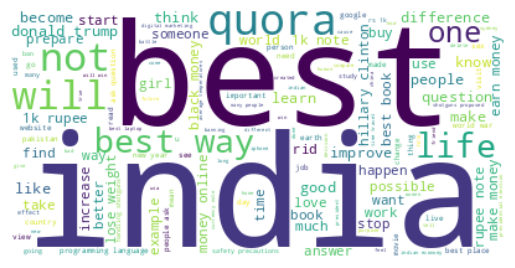

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


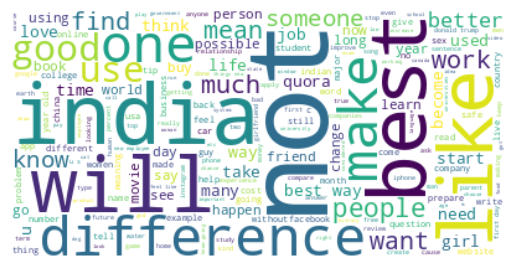

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

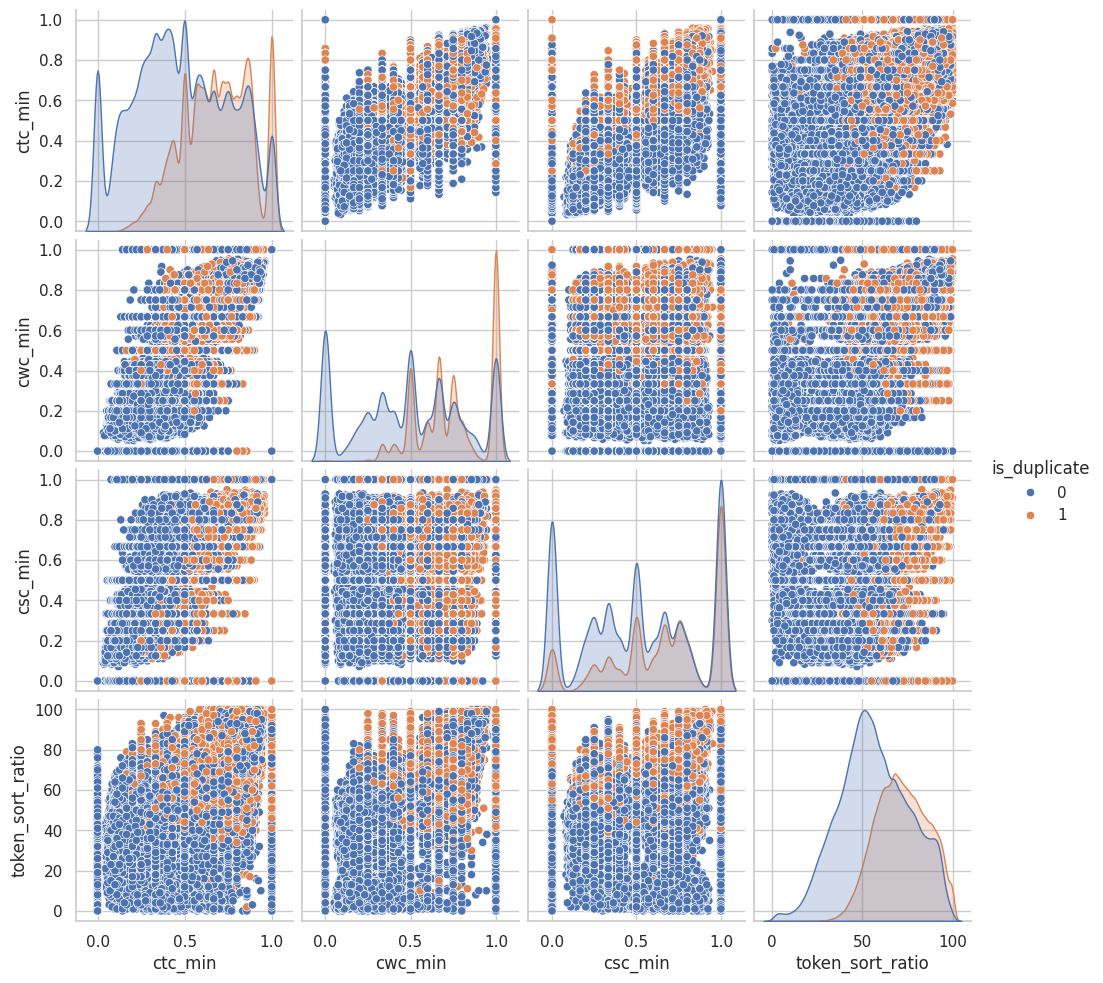

In [ ]:
len = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:len], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.771s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.443s
[t-SNE] Iteration 50: error = 85.6700897, gradient norm = 0.0846297 (50 iterations in 4.699s)
[t-SNE] Iteration 100: error = 70.9565353, gradient norm = 0.0135689 (50 iterations in 1.717s)
[t-SNE] Iteration 150: error = 68.9854965, gradient norm = 0.0077398 (50 iterations in 2.437s)
[t-SNE] Iteration 200: error = 68.1109009, gradient norm = 0.0056640 (50 iterations in 5.134s)
[t-SNE] Iteration 250: error = 67.5681458, gradient norm = 0.0042686

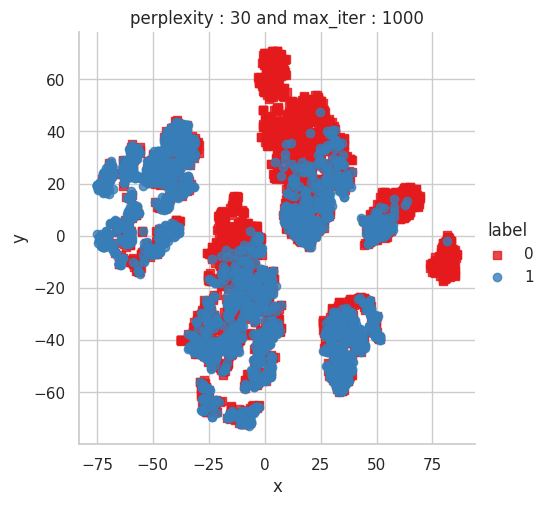

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()